/var/folders/x6/y_1j77ld0lndn2rh5d1xn9tw0000gn/T/ipykernel_12641/1698820078.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['cluster'] = kmeans.labels_
/var/folders/x6/y_1j77ld0lndn2rh5d1xn9tw0000gn/T/ipykernel_12641/1698820078.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['cluster'] = kmeans.labels_
/var/folders/x6/y_1j77ld0lndn2rh5d1xn9tw0000gn/T/ipykernel_12641/1698820078.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

size of slow_mid_points: 85
[ 0.10471285  0.3385063  79.43282347]


/var/folders/x6/y_1j77ld0lndn2rh5d1xn9tw0000gn/T/ipykernel_12641/1698820078.py:128: RuntimeWarning: invalid value encountered in log10
  predicted_y_fast = my_pwlf.predict(np.log10(predicted_x_fast))


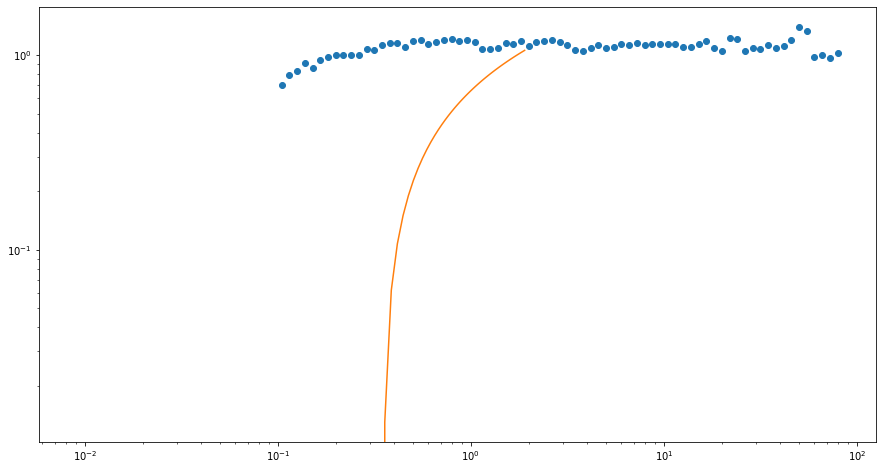

R^2 value: 0.6374465520402144
Slopes: [ 1.44539840e+00 -7.86424368e-04]
Intercepts: [0.65747767 1.14702034]


ValueError: negative dimensions are not allowed

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pwlf
import math 

# Load and preprocess data
df = pd.read_pickle("all_spcaecraft_data_scaled_v2024.05.p")
df.dropna(subset=["sc_r", "vp_m"], inplace=True)
df = df[df["vp_m"] > 0]

# Define bins and calculate geometric midpoints
bins = np.logspace(np.log10(0.1), np.log10(100), 76)
labels = range(len(bins)-1)
df['bins'] = pd.cut(df['sc_r'], bins=bins, include_lowest=True, labels=labels)
mid_points = np.sqrt(bins[:-1] * bins[1:])

# Calculate percentile cutoffs within each bin
percentile_cutoffs = df.groupby('bins')['vp_m'].quantile([0.30, 0.40]).unstack()

# Rename columns for clarity
percentile_cutoffs.columns = ['p30', 'p40']

# Merge percentile cutoffs into the main DataFrame
df = df.join(percentile_cutoffs, on='bins')

# Label data with wind speed categories
conditions = [
    df['vp_m'] <= df['p30'],
    (df['vp_m'] > df['p30']) & (df['vp_m'] <= df['p40']),
    df['vp_m'] > df['p40']
]
choices = ['slow', 'medium', 'fast']
df['wind_speed_category'] = np.select(conditions, choices, default='fast')

# Filter out rows with NaN means before plotting or modeling
df.dropna(subset=['p30', 'p40'], inplace=True)

# Initialize global variables
slow_mid_points = []
slow_means = []
medium_mid_points = []
medium_means = []
fast_mid_points = []
fast_means = []

def fit_and_store(category):
    subset = df[df['wind_speed_category'] == category]

    if not subset.empty:
        # Prepare the data for clustering
        log_sc_r = np.log(subset['sc_r'])
        log_vp_m = np.log(subset['vp_m'])
        cluster_data = np.vstack((log_sc_r, log_vp_m)).T

        # Apply the k-means algorithm with 3 clusters
        kmeans = KMeans(n_clusters=3, random_state=42).fit(cluster_data)
        subset['cluster'] = kmeans.labels_

        # Identify the breakpoints
        sorted_subset = subset.sort_values('sc_r')
        cluster_changes = np.where(sorted_subset['cluster'].values[:-1] != sorted_subset['cluster'].values[1:])[0]
        breakpoints = sorted_subset['sc_r'].iloc[cluster_changes].values
       
        # Split the data into segments defined by breakpoints
        segment_indices = [0] + list(cluster_changes + 1) + [len(sorted_subset)]
        
        for i in range(len(segment_indices) - 1):
            segment_data = sorted_subset.iloc[segment_indices[i]:segment_indices[i + 1]]
            segment_start = segment_data['sc_r'].min()
            segment_end = segment_data['sc_r'].max()
            
            grouped_means = segment_data.groupby('bins')['vp_m'].mean()
            valid_indices = ~grouped_means.isna()
            
            mid_points_valid = [mid_points[i] for i, valid in enumerate(valid_indices) if valid]
            means_valid = [grouped_means.iloc[i] for i, valid in enumerate(valid_indices) if valid]

            # Store valid mid_points and means in global variables
            if category == 'slow':
                slow_mid_points.extend(mid_points_valid)
                slow_means.extend(means_valid)
            elif category == 'medium':
                medium_mid_points.extend(mid_points_valid)
                medium_means.extend(means_valid)
            elif category == 'fast':
                fast_mid_points.extend(mid_points_valid)
                fast_means.extend(means_valid)

# Example usage for each category
fit_and_store('slow')
fit_and_store('medium')
fit_and_store('fast')

print("size of slow_mid_points:", len(slow_mid_points))

# For the fast solar winds 
seen = set()
unique_x_values = []
unique_y_values = []

for x, y in zip(fast_mid_points, fast_means):
    if x not in seen:
        unique_x_values.append((x))
        unique_y_values.append((y))
        seen.add(x)

highest_value_x = max(unique_x_values)
highest_value_y_index = unique_x_values.index(highest_value_x)
unique_y_values.pop(highest_value_y_index)
unique_x_values.remove(highest_value_x)

second_highest_value_x = max(unique_x_values)
second_highest_value_y_index = unique_x_values.index(second_highest_value_x)
unique_y_values.pop(second_highest_value_y_index)
unique_x_values.remove(second_highest_value_x)

my_pwlf = pwlf.PiecewiseLinFit(unique_x_values, unique_y_values)
breaks = my_pwlf.fit(2)
print(breaks)

numpy_array_fast = np.array(unique_x_values)
predicted_x_fast = np.linspace(np.log10(numpy_array_fast.min()), np.log10(numpy_array_fast.max()), 100)
predicted_y_fast = my_pwlf.predict(np.log10(predicted_x_fast))

plt.figure(figsize=(15, 8)) 
plt.xscale("log")
plt.yscale("log")
plt.plot(unique_x_values, unique_y_values, 'o')
plt.plot(predicted_x_fast, predicted_y_fast, '-')
plt.show()

R_squared = my_pwlf.r_squared()
print(f'R^2 value: {R_squared}')
slopes = my_pwlf.slopes
intercepts = my_pwlf.intercepts
print("Slopes:", slopes)
print("Intercepts:", intercepts)

# For the medium solar winds 
seen = set()
unique_x_values = []
unique_y_values = []

for x, y in zip(medium_mid_points, medium_means):
    if x not in seen:
        unique_x_values.append(x)
        unique_y_values.append(y)
        seen.add(x)

highest_value_x = max(unique_x_values)
highest_value_y_index = unique_x_values.index(highest_value_x)
unique_y_values.pop(highest_value_y_index)
unique_x_values.remove(highest_value_x)

second_highest_value_x = max(unique_x_values)
second_highest_value_y_index = unique_x_values.index(second_highest_value_x)
unique_y_values.pop(second_highest_value_y_index)
unique_x_values.remove(second_highest_value_x)

# print('shape',type(unique_x_values))
my_pwlf = pwlf.PiecewiseLinFit((unique_x_values), (unique_y_values))
breaks = my_pwlf.fit(n_segments=0)
print(breaks)

numpy_array_fast = np.array(unique_x_values)
predicted_x_fast = np.linspace(numpy_array_fast.min(), numpy_array_fast.max(), 100)
predicted_y_fast = my_pwlf.predict(predicted_x_fast)

plt.figure(figsize=(15, 8)) 
plt.xscale("log")
plt.yscale("log")
plt.plot(unique_x_values, unique_y_values, 'o')
plt.plot(predicted_x_fast, predicted_y_fast, '-')
plt.title('2nd graph')
plt.show()

R_squared = my_pwlf.r_squared()
print(f'R^2 value: {R_squared}')
slopes = my_pwlf.slopes
intercepts = my_pwlf.intercepts
print("Slopes:", slopes)
print("Intercepts:", intercepts)

# For the slow solar winds 
seen = set()
unique_x_values = []
unique_y_values = []

for x, y in zip(slow_mid_points, slow_means):
    if x not in seen:
        unique_x_values.append(x)
        unique_y_values.append(y)
        seen.add(x)

highest_value_x = max(unique_x_values)
highest_value_y_index = unique_x_values.index(highest_value_x)
unique_y_values.pop(highest_value_y_index)
unique_x_values.remove(highest_value_x)

second_highest_value_x = max(unique_x_values)
second_highest_value_y_index = unique_x_values.index(second_highest_value_x)
unique_y_values.pop(second_highest_value_y_index)
unique_x_values.remove(second_highest_value_x)

my_pwlf = pwlf.PiecewiseLinFit(unique_x_values, unique_y_values)
breaks = my_pwlf.fit(10)
print(breaks)

numpy_array_fast = np.array(unique_x_values)
predicted_x_fast = np.linspace(numpy_array_fast.min(), numpy_array_fast.max(), 100)
predicted_y_fast = my_pwlf.predict(predicted_x_fast)

plt.figure(figsize=(15, 8)) 
plt.plot(unique_x_values, unique_y_values, 'o')
plt.xscale("log")
plt.yscale("log")
plt.plot(predicted_x_fast, predicted_y_fast, '-')
plt.show()

R_squared = my_pwlf.r_squared()
print(f'R^2 value: {R_squared}')
slopes = my_pwlf.slopes
intercepts = my_pwlf.intercepts
print("Slopes:", slopes)
print("Intercepts:", intercepts)

def save_to_csv():
    slow_df = pd.DataFrame({'mid_points': slow_mid_points, 'means': slow_means})
    slow_df.to_csv('slow_wind_speed_data.csv', index=False)

    medium_df = pd.DataFrame({'mid_points': medium_mid_points, 'means': medium_means})
    medium_df.to_csv('medium_wind_speed_data.csv', index=False)

    fast_df = pd.DataFrame({'mid_points': fast_mid_points, 'means': fast_means})
    fast_df.to_csv('fast_wind_speed_data.csv', index=False)
    
save_to_csv()



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pwlf
import math 

# Load and preprocess data
df = pd.read_pickle("all_spcaecraft_data_scaled_v2024.05.p")
df.dropna(subset=["sc_r", "vp_m"], inplace=True)
df = df[df["vp_m"] > 0]

# Define bins and calculate geometric midpoints
bins = np.logspace(np.log10(0.1), np.log10(100), 76)
labels = range(len(bins)-1)
df['bins'] = pd.cut(df['sc_r'], bins=bins, include_lowest=True, labels=labels)
mid_points = np.sqrt(bins[:-1] * bins[1:])
mid_points_list = mid_points.tolist()
print("mid_points_list length:", len(mid_points_list))

# Calculate percentile cutoffs within each bin
percentile_cutoffs = df.groupby('bins')['vp_m'].quantile([0.30, 0.40]).unstack()

# Rename columns for clarity
percentile_cutoffs.columns = ['p30', 'p40']

# Merge percentile cutoffs into the main DataFrame
df = df.join(percentile_cutoffs, on='bins')

# Label data with wind speed categories
conditions = [
    df['vp_m'] <= df['p30'],
    (df['vp_m'] > df['p30']) & (df['vp_m'] <= df['p40']),
    df['vp_m'] > df['p40']
]
choices = ['slow', 'medium', 'fast']
df['wind_speed_category'] = np.select(conditions, choices, default='fast')

# Filter out rows with NaN means before plotting or modeling
df.dropna(subset=['p30', 'p40'], inplace=True)

# Create empty lists for each choice
vp_m_slow = []
vp_m_medium = []
vp_m_fast = []

# Loop through each choice and extract the corresponding sc_r and vp_m
for choice in choices:
    filtered_df = df[df['wind_speed_category'] == choice]
    if choice == 'slow':
        vp_m_slow = filtered_df['vp_m'].tolist()
    elif choice == 'medium':
        vp_m_medium = filtered_df['vp_m'].tolist()
    elif choice == 'fast':
        vp_m_fast = filtered_df['vp_m'].tolist()

# FOR THE FAST SOLAR WINDS 

# Remove the outliers (i.e. last two points)
highest_value_x = max(mid_points_list)
highest_value_y_index = mid_points_list.index(highest_value_x)
vp_m_fast.pop(highest_value_y_index)
mid_points_list.remove(highest_value_x)

second_highest_value_x = max(mid_points_list)
second_highest_value_y_index = mid_points_list.index(second_highest_value_x)
vp_m_fast.pop(second_highest_value_y_index)
mid_points_list.remove(second_highest_value_x)

print("Length of mid_points_list:", len(mid_points_list))
print("Length of vp_m_fast:", len(vp_m_fast))

# Generate the model using a package implementing curve_fit
my_pwlf = pwlf.PiecewiseLinFit(mid_points_list, vp_m_fast)
breaks = my_pwlf.fit(2)
print(breaks)

predicted_y_fast = my_pwlf.predict(mid_points_list)

plt.figure(figsize=(15, 8)) 
plt.xscale("log")
plt.yscale("log")
plt.plot(mid_points_list, vp_m_fast, 'o')
plt.plot(mid_points_list, predicted_y_fast, '-')
plt.show()

R_squared = my_pwlf.r_squared()
print(f'R^2 value: {R_squared}')
slopes = my_pwlf.slopes
intercepts = my_pwlf.intercepts
print("Slopes:", slopes)
print("Intercepts:", intercepts)



mid_points_list length: 75
Length of mid_points_list: 73
Length of vp_m_fast: 208760


RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

FOR THE FAST SOLAR WINDS

The breakpoints are located at:  [-0.94       -0.72784701 -0.37688994  1.9       ]


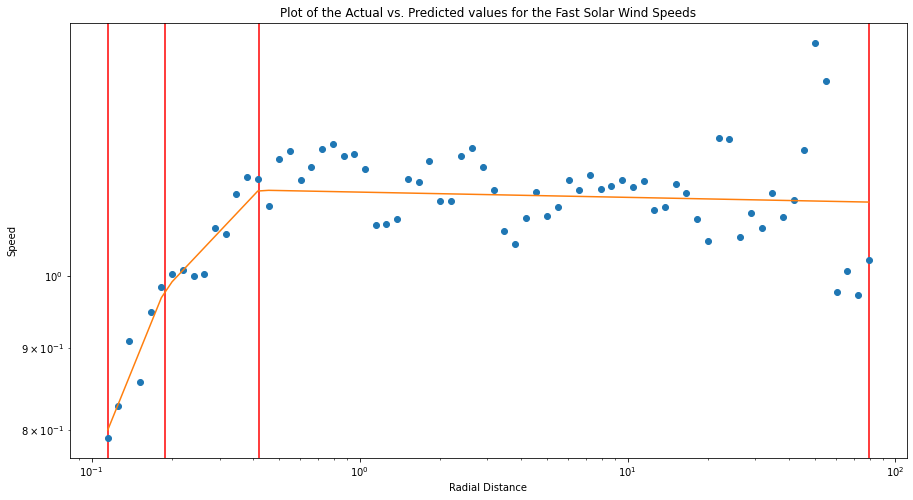

Chi-squared statistic: 0.2748
Does the model fit the data well? True
Slopes: [ 0.41519566  0.17811532 -0.00329357]
Intercepts: [0.2933746  0.12081638 0.0524452 ]

FOR THE MEDIUM SOLAR WINDS

The breakpoints are located at:  [-0.9         0.23634818  1.9       ]


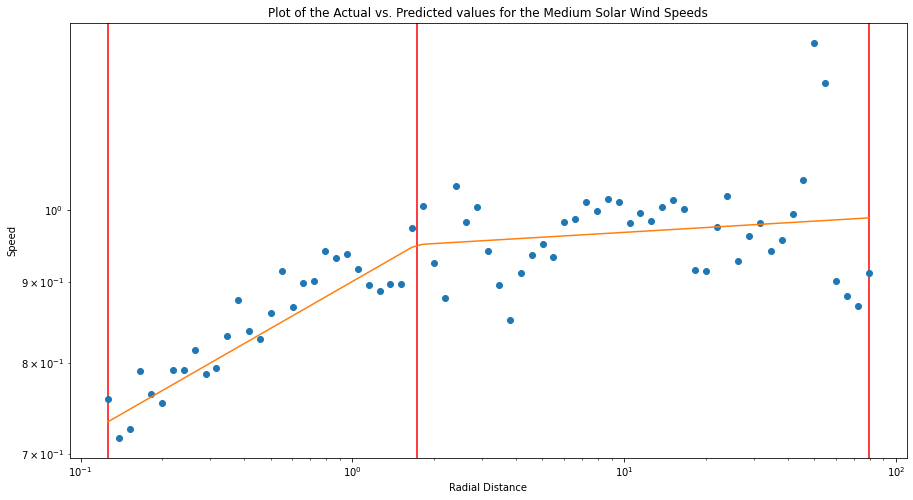

Chi-squared statistic: 0.2798
Does the model fit the data well? True
Slopes: [0.09917276 0.01020902]
Intercepts: [-0.04536457 -0.02433816]

FOR THE SLOW SOLAR WINDS

The breakpoints are located at:  [-0.9        -0.36004157  1.9       ]


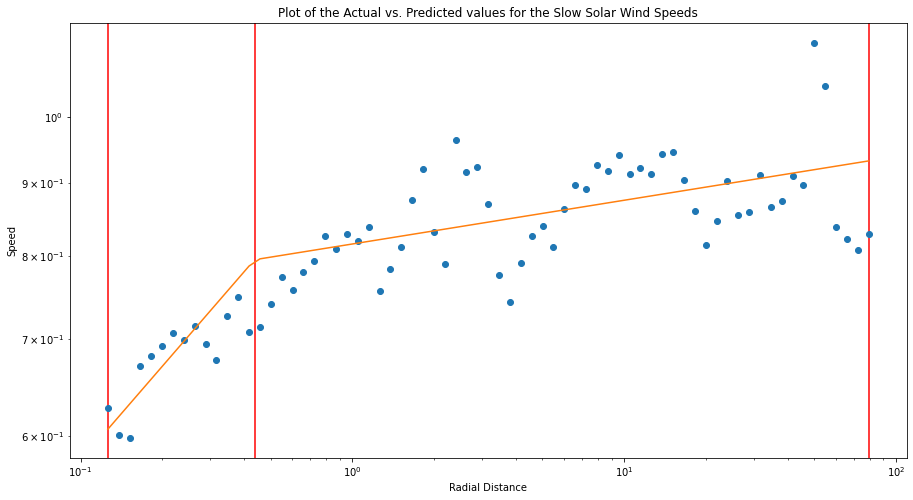

Chi-squared statistic: 0.2822
Does the model fit the data well? True
Slopes: [0.21846711 0.0304196 ]
Intercepts: [-0.02075559 -0.08846051]



In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import chi2
import pwlf
import math 

# Load and preprocess data
df = pd.read_pickle("all_spcaecraft_data_scaled_v2024.05.p")
df.dropna(subset=["sc_r", "vp_m"], inplace=True)
df = df[df["vp_m"] > 0]

# Define bins and calculate geometric midpoints
bins = np.logspace(np.log10(0.1), np.log10(100), 76)
labels = range(len(bins) - 1)
df['bins'] = pd.cut(df['sc_r'], bins=bins, include_lowest=True, labels=labels)
mid_points = np.sqrt(bins[:-1] * bins[1:])

# Calculate percentile cutoffs within each bin
percentile_cutoffs = df.groupby('bins')['vp_m'].quantile([0.30, 0.40]).unstack()

# Rename columns for clarity
percentile_cutoffs.columns = ['p30', 'p40']

# Merge percentile cutoffs into the main DataFrame
df = df.join(percentile_cutoffs, on='bins')

# Label data with wind speed categories
conditions = [
    df['vp_m'] <= df['p30'],
    (df['vp_m'] > df['p30']) & (df['vp_m'] <= df['p40']),
    df['vp_m'] > df['p40']
]
choices = ['slow', 'medium', 'fast']
df['wind_speed_category'] = np.select(conditions, choices, default='fast')

# Filter out rows with NaN means before plotting or modeling
df.dropna(subset=['p30', 'p40'], inplace=True)

# Group by bins and wind_speed_category and calculate the mean vp_m for each group
mean_vp_m = df.groupby(['bins', 'wind_speed_category'])['vp_m'].mean().unstack()

# Create lists for the average vp_m values per bin for each category
vp_m_slow = mean_vp_m['slow'].tolist()
vp_m_medium = mean_vp_m['medium'].tolist()
vp_m_fast = mean_vp_m['fast'].tolist()

# Convert mid_points to a list
mid_points_list = mid_points.tolist()

# Function to calculate weights (inverse of the standard deviation in each bin)
def calculate_weights(category):
    weights_1 = df[df['wind_speed_category'] == category].groupby('bins')['vp_m'].size()
    total = df[df['wind_speed_category'] == category].groupby('bins')['vp_m'].count()
    weights_2 = np.sqrt(weights_1) / total
    #weights_2 = np.sqrt(weights_1)
    weights_2 = weights_2.fillna(0).tolist()
    # Normalize weights
    return weights_2
    #return [w / max(weights_1) for w in weights_2]  

# Function to compute the Chi-squared statistic for each model
def chi_squared_test(observed, predicted, degrees_freedom, alpha=0.05):

    squared_residuals = [(obs - pred)**2 / pred for obs, pred in zip(observed, predicted)]
    chi_squared_stat = sum(squared_residuals)
    
    p_value = 1 - chi2.cdf(chi_squared_stat, degrees_freedom)
    
    if p_value < alpha:
        fit_result = False
    else:
        fit_result = True
    
    return chi_squared_stat, p_value, fit_result

# Calculate weights for each category
weights_slow = calculate_weights('slow')
weights_medium = calculate_weights('medium')
weights_fast = calculate_weights('fast')

# FOR THE FAST SOLAR WINDS 
print("FOR THE FAST SOLAR WINDS")
print()

# Remove the outliers (i.e. last two points and first point) 
highest_value_x = max(mid_points_list)
highest_value_y_index = mid_points_list.index(highest_value_x)
vp_m_fast.pop(highest_value_y_index)
mid_points_list.remove(highest_value_x)
weights_fast.pop(highest_value_y_index)

second_highest_value_x = max(mid_points_list)
second_highest_value_y_index = mid_points_list.index(second_highest_value_x)
vp_m_fast.pop(second_highest_value_y_index)
mid_points_list.remove(second_highest_value_x)
weights_fast.pop(second_highest_value_y_index)

lowest_value_x = min(mid_points_list)
lowest_value_y_index = mid_points_list.index(lowest_value_x)
vp_m_fast.pop(lowest_value_y_index)
mid_points_list.remove(lowest_value_x)
weights_fast.pop(lowest_value_y_index)

# Generate the model using a package implementing curve_fit
my_pwlf = pwlf.PiecewiseLinFit(np.log10(mid_points_list), np.log10(vp_m_fast), weights=weights_fast)
breaks = my_pwlf.fit(3)
print("The breakpoints are located at: ", breaks)

predicted_y_fast = my_pwlf.predict(np.log10(mid_points_list))

plt.figure(figsize=(15, 8)) 
plt.xscale("log")
plt.yscale("log")
for b in breaks:
    plt.axvline(10**b, color='r')
plt.plot(mid_points_list, vp_m_fast, 'o')
plt.plot(mid_points_list, 10**predicted_y_fast, '-')
plt.ylabel("Speed")
plt.xlabel("Radial Distance")
plt.title("Plot of the Actual vs. Predicted values for the Fast Solar Wind Speeds")
plt.savefig('fast_solar_winds.png', dpi=100, bbox_inches='tight')
plt.show()

slopes = my_pwlf.slopes
intercepts = my_pwlf.intercepts
observed_fast = vp_m_fast
predicted_fast = 10**predicted_y_fast
degrees_freedom = len(observed_fast) - len(slopes) - len(intercepts) - 1  
chi_squared_stat, p_value, fit_result = chi_squared_test(observed_fast, predicted_fast, degrees_freedom)
print(f"Chi-squared statistic: {chi_squared_stat:.4f}")
print(f"Does the model fit the data well? {fit_result}")
print("Slopes:", slopes)
print("Intercepts:", intercepts)
print()

fast_winds_data = {'Radial Distance': mid_points_list, 'Speed': vp_m_fast}
fast_winds_df = pd.DataFrame(fast_winds_data)
fast_winds_df.to_csv('fast_solar_winds.csv', index=False)

# FOR THE MEDIUM SOLAR WINDS 
print("FOR THE MEDIUM SOLAR WINDS")
print()

# Remove the outliers (i.e. last two points and first two points)
vp_m_medium.pop(highest_value_y_index)
vp_m_medium.pop(second_highest_value_y_index)
weights_medium.pop(highest_value_y_index)
weights_medium.pop(second_highest_value_y_index)

vp_m_medium.pop(lowest_value_y_index)
weights_medium.pop(lowest_value_y_index)

second_lowest_value_x = min(mid_points_list)
second_lowest_value_y_index = mid_points_list.index(second_lowest_value_x)
vp_m_medium.pop(second_lowest_value_y_index)
mid_points_list.remove(second_lowest_value_x)
weights_medium.pop(second_lowest_value_y_index)

# Generate the model using a package implementing curve_fit
my_pwlf = pwlf.PiecewiseLinFit(np.log10(mid_points_list), np.log10(vp_m_medium), weights = weights_medium)
breaks = my_pwlf.fit(2)
print("The breakpoints are located at: ", breaks)

predicted_y_fast = my_pwlf.predict(np.log10(mid_points_list))

plt.figure(figsize=(15, 8)) 
plt.xscale("log")
plt.yscale("log")
for b in breaks:
    plt.axvline(10**b, color='r')
plt.plot(mid_points_list, vp_m_medium, 'o')
plt.plot(mid_points_list, 10**predicted_y_fast, '-')
plt.ylabel("Speed")
plt.xlabel("Radial Distance")
plt.title("Plot of the Actual vs. Predicted values for the Medium Solar Wind Speeds")
plt.savefig('medium_solar_winds.png', dpi=100, bbox_inches='tight')
plt.show()

slopes = my_pwlf.slopes
intercepts = my_pwlf.intercepts
observed_medium = vp_m_medium
predicted_medium = 10**predicted_y_fast
degrees_freedom = len(observed_medium) - len(slopes) - len(intercepts) - 1  
chi_squared_stat, p_value, fit_result = chi_squared_test(observed_medium, predicted_medium, degrees_freedom)
print(f"Chi-squared statistic: {chi_squared_stat:.4f}")
print(f"Does the model fit the data well? {fit_result}")
print("Slopes:", slopes)
print("Intercepts:", intercepts)
print()

medium_winds_data = {'Radial Distance': mid_points_list, 'Speed': vp_m_medium}
medium_winds_df = pd.DataFrame(medium_winds_data)
medium_winds_df.to_csv('medium_solar_winds.csv', index=False)

# FOR THE SLOW SOLAR WINDS 
print("FOR THE SLOW SOLAR WINDS")
print()

# Remove the last two points and the first two points
vp_m_slow.pop(highest_value_y_index)
vp_m_slow.pop(second_highest_value_y_index)
weights_slow.pop(highest_value_y_index)
weights_slow.pop(second_highest_value_y_index)

vp_m_slow.pop(lowest_value_y_index)
weights_slow.pop(lowest_value_y_index)
vp_m_slow.pop(second_lowest_value_y_index)
weights_slow.pop(second_lowest_value_y_index)

# Generate the model using a package implementing curve_fit
my_pwlf = pwlf.PiecewiseLinFit(np.log10(mid_points_list), np.log10(vp_m_slow), weights = weights_slow)
breaks = my_pwlf.fit(2)
print("The breakpoints are located at: ", breaks)

predicted_y_fast = my_pwlf.predict(np.log10(mid_points_list))

plt.figure(figsize=(15, 8)) 
plt.xscale("log")
plt.yscale("log")
for b in breaks:
    plt.axvline(10**b, color='r')
plt.plot(mid_points_list, vp_m_slow, 'o')
plt.plot(mid_points_list, 10**predicted_y_fast, '-')
plt.ylabel("Speed")
plt.xlabel("Radial Distance")
plt.title("Plot of the Actual vs. Predicted values for the Slow Solar Wind Speeds")
plt.savefig('slow_solar_winds.png', dpi=100, bbox_inches='tight')
plt.show()

slopes = my_pwlf.slopes
intercepts = my_pwlf.intercepts
observed_slow = vp_m_slow
predicted_slow = 10**predicted_y_fast
degrees_freedom = len(observed_slow) - len(slopes) - len(intercepts) - 1  
chi_squared_stat, p_value, fit_result = chi_squared_test(observed_slow, predicted_slow, degrees_freedom)
print(f"Chi-squared statistic: {chi_squared_stat:.4f}")
print(f"Does the model fit the data well? {fit_result}")
print("Slopes:", slopes)
print("Intercepts:", intercepts)
print()

slow_winds_data = {'Radial Distance': mid_points_list, 'Speed': vp_m_slow}
slow_winds_df = pd.DataFrame(slow_winds_data)
slow_winds_df.to_csv('slow_solar_winds.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import chi2
import pwlf
import math 

# Load and preprocess data
df = pd.read_pickle("all_spcaecraft_data_scaled_v2024.05.p")
df.dropna(subset=["sc_r", "vp_m"], inplace=True)
df = df[df["vp_m"] > 0]

# Define bins and calculate geometric midpoints
bins = np.logspace(np.log10(0.1), np.log10(100), 76)
labels = range(len(bins) - 1)
df['bins'] = pd.cut(df['sc_r'], bins=bins, include_lowest=True, labels=labels)
mid_points = np.sqrt(bins[:-1] * bins[1:])

# Calculate percentile cutoffs within each bin
percentile_cutoffs = df.groupby('bins')['vp_m'].quantile([0.30, 0.40]).unstack()

# Rename columns for clarity
percentile_cutoffs.columns = ['p30', 'p40']

# Merge percentile cutoffs into the main DataFrame
df = df.join(percentile_cutoffs, on='bins')

# Label data with wind speed categories
conditions = [
    df['vp_m'] <= df['p30'],
    (df['vp_m'] > df['p30']) & (df['vp_m'] <= df['p40']),
    df['vp_m'] > df['p40']
]
choices = ['slow', 'medium', 'fast']
df['wind_speed_category'] = np.select(conditions, choices, default='fast')

# Filter out rows with NaN means before plotting or modeling
df.dropna(subset=['p30', 'p40'], inplace=True)

# Group by bins and wind_speed_category and calculate the mean vp_m for each group
mean_vp_m = df.groupby(['bins', 'wind_speed_category'])['vp_m'].mean().unstack()

# Create lists for the average vp_m values per bin for each category
vp_m_slow = mean_vp_m['slow'].tolist()
vp_m_medium = mean_vp_m['medium'].tolist()
vp_m_fast = mean_vp_m['fast'].tolist()

# Convert mid_points to a list
mid_points_list = mid_points.tolist()

# Function to calculate weights (inverse of the standard deviation in each bin)
def calculate_weights(category):
    weights_1 = df[df['wind_speed_category'] == category].groupby('bins')['vp_m'].size()
    total = df[df['wind_speed_category'] == category].groupby('bins')['vp_m'].count()
    weights_2 = np.sqrt(weights_1) 
    weights_2 = weights_2.fillna(0).tolist()
    # Normalize weights
    #return weights_2
    return [w / max(weights_1) for w in weights_2]  

# Function to compute the Chi-squared statistic for each model
def chi_squared_test(observed, predicted, degrees_freedom, alpha=0.05):

    squared_residuals = [(obs - pred)**2 / pred for obs, pred in zip(observed, predicted)]
    chi_squared_stat = sum(squared_residuals)
    
    p_value = 1 - chi2.cdf(chi_squared_stat, degrees_freedom)
    
    if p_value < alpha:
        fit_result = False
    else:
        fit_result = True
    
    return chi_squared_stat, p_value, fit_result

# Calculate weights for each category
weights_slow = calculate_weights('slow')
weights_medium = calculate_weights('medium')
weights_fast = calculate_weights('fast')

# FOR THE FAST SOLAR WINDS 
print("FOR THE FAST SOLAR WINDS")
print()

# Remove the outliers (i.e. last two points and first point) 
highest_value_x = max(mid_points_list)
highest_value_y_index = mid_points_list.index(highest_value_x)
vp_m_fast.pop(highest_value_y_index)
mid_points_list.remove(highest_value_x)
weights_fast.pop(highest_value_y_index)

second_highest_value_x = max(mid_points_list)
second_highest_value_y_index = mid_points_list.index(second_highest_value_x)
vp_m_fast.pop(second_highest_value_y_index)
mid_points_list.remove(second_highest_value_x)
weights_fast.pop(second_highest_value_y_index)

lowest_value_x = min(mid_points_list)
lowest_value_y_index = mid_points_list.index(lowest_value_x)
vp_m_fast.pop(lowest_value_y_index)
mid_points_list.remove(lowest_value_x)
weights_fast.pop(lowest_value_y_index)

# Generate the model using a package implementing curve_fit
my_pwlf = pwlf.PiecewiseLinFit(np.log10(mid_points_list), np.log10(vp_m_fast), weights=weights_fast)
breaks = my_pwlf.fit(3)
print("The breakpoints are located at: ", breaks)

predicted_y_fast = my_pwlf.predict(np.log10(mid_points_list))

plt.figure(figsize=(15, 8)) 
plt.xscale("log")
plt.yscale("log")
for b in breaks:
    plt.axvline(10**b, color='r')
plt.plot(mid_points_list, vp_m_fast, 'o')
plt.plot(mid_points_list, 10**predicted_y_fast, '-')
plt.ylabel("Speed")
plt.xlabel("Radial Distance")
plt.title("Plot of the Actual vs. Predicted values for the Fast Solar Wind Speeds")
plt.savefig('fast_solar_winds_sqrt(n)_weight.png', dpi=100, bbox_inches='tight')
plt.show()

slopes = my_pwlf.slopes
intercepts = my_pwlf.intercepts
observed_fast = vp_m_fast
predicted_fast = 10**predicted_y_fast
degrees_freedom = len(observed_fast) - len(slopes) - len(intercepts) - 1  
chi_squared_stat, p_value, fit_result = chi_squared_test(observed_fast, predicted_fast, degrees_freedom)
print(f"Chi-squared statistic: {chi_squared_stat:.4f}")
print(f"Does the model fit the data well? {fit_result}")
print("Slopes:", slopes)
print("Intercepts:", intercepts)
print()

fast_winds_data = {'Radial Distance': mid_points_list, 'Speed': vp_m_fast}
fast_winds_df = pd.DataFrame(fast_winds_data)
fast_winds_df.to_csv('fast_solar_winds.csv', index=False)

# FOR THE MEDIUM SOLAR WINDS 
print("FOR THE MEDIUM SOLAR WINDS")
print()

# Remove the outliers (i.e. last two points and first two points)
vp_m_medium.pop(highest_value_y_index)
vp_m_medium.pop(second_highest_value_y_index)
weights_medium.pop(highest_value_y_index)
weights_medium.pop(second_highest_value_y_index)

vp_m_medium.pop(lowest_value_y_index)
weights_medium.pop(lowest_value_y_index)

second_lowest_value_x = min(mid_points_list)
second_lowest_value_y_index = mid_points_list.index(second_lowest_value_x)
vp_m_medium.pop(second_lowest_value_y_index)
mid_points_list.remove(second_lowest_value_x)
weights_medium.pop(second_lowest_value_y_index)

# Generate the model using a package implementing curve_fit
my_pwlf = pwlf.PiecewiseLinFit(np.log10(mid_points_list), np.log10(vp_m_medium), weights = weights_medium)
breaks = my_pwlf.fit(2)
print("The breakpoints are located at: ", breaks)

predicted_y_fast = my_pwlf.predict(np.log10(mid_points_list))

plt.figure(figsize=(15, 8)) 
plt.xscale("log")
plt.yscale("log")
for b in breaks:
    plt.axvline(10**b, color='r')
plt.plot(mid_points_list, vp_m_medium, 'o')
plt.plot(mid_points_list, 10**predicted_y_fast, '-')
plt.ylabel("Speed")
plt.xlabel("Radial Distance")
plt.title("Plot of the Actual vs. Predicted values for the Medium Solar Wind Speeds")
plt.savefig('medium_solar_winds_sqrt(n)_weight.png', dpi=100, bbox_inches='tight')
plt.show()

slopes = my_pwlf.slopes
intercepts = my_pwlf.intercepts
observed_medium = vp_m_medium
predicted_medium = 10**predicted_y_fast
degrees_freedom = len(observed_medium) - len(slopes) - len(intercepts) - 1  
chi_squared_stat, p_value, fit_result = chi_squared_test(observed_medium, predicted_medium, degrees_freedom)
print(f"Chi-squared statistic: {chi_squared_stat:.4f}")
print(f"Does the model fit the data well? {fit_result}")
print("Slopes:", slopes)
print("Intercepts:", intercepts)
print()

medium_winds_data = {'Radial Distance': mid_points_list, 'Speed': vp_m_medium}
medium_winds_df = pd.DataFrame(medium_winds_data)
medium_winds_df.to_csv('medium_solar_winds.csv', index=False)

# FOR THE SLOW SOLAR WINDS 
print("FOR THE SLOW SOLAR WINDS")
print()

# Remove the last two points and the first two points
vp_m_slow.pop(highest_value_y_index)
vp_m_slow.pop(second_highest_value_y_index)
weights_slow.pop(highest_value_y_index)
weights_slow.pop(second_highest_value_y_index)

vp_m_slow.pop(lowest_value_y_index)
weights_slow.pop(lowest_value_y_index)
vp_m_slow.pop(second_lowest_value_y_index)
weights_slow.pop(second_lowest_value_y_index)

# Generate the model using a package implementing curve_fit
my_pwlf = pwlf.PiecewiseLinFit(np.log10(mid_points_list), np.log10(vp_m_slow), weights = weights_slow)
breaks = my_pwlf.fit(2)
print("The breakpoints are located at: ", breaks)

predicted_y_fast = my_pwlf.predict(np.log10(mid_points_list))

plt.figure(figsize=(15, 8)) 
plt.xscale("log")
plt.yscale("log")
for b in breaks:
    plt.axvline(10**b, color='r')
plt.plot(mid_points_list, vp_m_slow, 'o')
plt.plot(mid_points_list, 10**predicted_y_fast, '-')
plt.ylabel("Speed")
plt.xlabel("Radial Distance")
plt.title("Plot of the Actual vs. Predicted values for the Slow Solar Wind Speeds")
plt.savefig('slow_solar_winds_sqrt(n)_weight.png', dpi=100, bbox_inches='tight')
plt.show()

slopes = my_pwlf.slopes
intercepts = my_pwlf.intercepts
observed_slow = vp_m_slow
predicted_slow = 10**predicted_y_fast
degrees_freedom = len(observed_slow) - len(slopes) - len(intercepts) - 1  
chi_squared_stat, p_value, fit_result = chi_squared_test(observed_slow, predicted_slow, degrees_freedom)
print(f"Chi-squared statistic: {chi_squared_stat:.4f}")
print(f"Does the model fit the data well? {fit_result}")
print("Slopes:", slopes)
print("Intercepts:", intercepts)
print()

slow_winds_data = {'Radial Distance': mid_points_list, 'Speed': vp_m_slow}
slow_winds_df = pd.DataFrame(slow_winds_data)
slow_winds_df.to_csv('slow_solar_winds.csv', index=False)